## TODO 

#### general: 

* General Analysis
* Try different Sentiment Analysis Tools

* ~Complete the sampling of all tweets from that day 01.12.2022.~
* ~Meeting with Tutor at 13:30~
* ~Try to add geolocation data~
* ~Try to add user data~

#### today: 

* ~Read into query composition~
* ~Add user and place extension~
* ~Write Jira Ticket board~
* Specifiy dates in which we want to sample:
* Compose list of dates automatically 
* Choose Keywords to include in the request
* Limit to US?
* Restructure query cell such that it sends request per value in the 


# Data Literacy Student Project

### Main Question : Has the amount of transphobic tweets increased under Elon Musk?



This notebook was created as part of the team project for the Data Literacy course. The code for the data analysis project has been carried out in this jupyter notebook and is the work of 

    Fabian K√∂ninger  4200890   fabian.koeninger@student.uni-tuebingen.de
    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project tackles the question if the amount of transphobic tweets has increased since the takeover of Twitter by Elon Musk. 
The background to this projecte idea aroused by Elon Musks 44 billion USD takeover of twitter on 27th of October 2022. 
One day after the takeover, on 28th of October 20222, Musk tweeted that "Anyone suspended for minor & dubious reasons will be freed from Twitter jail". Musk describes himself as an "absolutist of free speach", which lead to LGBTQ people that fear the harrassment they might face after the takeover. 

This notebook ist designed in the following structure:

### Outline

* [1. Setup](#setup_section)
* [2. Authentification](#authentification_section)
* [3. Composition of Dataset](#crawling_section)
* [4. General Data Anaylsis](#general_analysis)
* [5. Sentiment Analysis](#sentiment_analysis)
* [6. Wordcloud](#wordcloud)

### <a name="setup_section"></a> 1. Setup: Manage Installations and Imports

In [1]:
# Installations
# Comment out the following line in case you have not already included any of the following libraries 
# that are required for this notebook in your setup 
# 1. Tweepy
# 2. Textblob
# 3. Wordcloud

#!pip install tweepy
#!pip install textblob
#!python -m textblob.download_corpora
#!pip install wordcloud


#Imports
import tweepy
import json
import datetime 
import os
import pandas as pd
import csv
import time
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta 
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


###  <a name="authentification_section"></a> 2. Authentifaction: Set Credentials to access the Twitter API

In [2]:
# Think of the API key as the user name that represents your App when making API requests. It helps us verify who you are.
api_key = 'ejMMb5Cvj2d6s0gwDAJi3Y9Cc'  

# Your API Key Secret is like a password and helps verify your API Key. This will be one of the last times you'll see it displayed, so remember to save it in a safe place.
api_key_secret= 'RNZEFHl3PAtQkxpZTC1YliGbfcSdjlL4SnuX6fnR1PWJ1xDbGW'

# An Access Token used in authentication that allows you to pull specific data.
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAIUAkwEAAAAAyQuxM73RN3fkHhDCy%2BConF0mzjg%3DIK6iouUoVLUcseqcoSOYs3wZYSRfsrlzXsfRO2ac5uk6EYTQX7'

In [3]:
os.environ['Twitter_Bearer_Token'] = bearer_token

In [4]:
def auth():
    return os.getenv('Twitter_Bearer_Token')

In [5]:
client = tweepy.Client(bearer_token=auth())

In [6]:

# Authentification Setup

consumer_key = 'ejMMb5Cvj2d6s0gwDAJi3Y9Cc'
consumer_secret = 'RNZEFHl3PAtQkxpZTC1YliGbfcSdjlL4SnuX6fnR1PWJ1xDbGW'
access_token = '1600184977420963845-iCZd2SeMRDtUusQOJofjNDYtJadGNB'
access_secret = 'TFwzBo8ZzppEWfQX5n0Dq1jWhT9eHEjpu53tpjnOh5MCC'


oAuth = tweepy.OAuth1UserHandler(
    consumer_key,
    consumer_secret,
    access_token,
    access_secret
)

api = tweepy.API(oAuth)



###  <a name="crawling_section"></a> 3. Composition of Dataset

In this section we build and send the requests to Twitters API in order to retrieve and build our dataset for the analysis.
We want to get all the tweets during the timespam from 01.01.2022 to 31.12.2022 in order to cover a whole year and get a sufficient timespan before and after Elon Musks takeover. 

We crawl all tweets that contain 'LGBTQ' in their message and were created during our defined timespan. 

### Helper functions

In [7]:
"""
This function processes a response from Twitters API and converts it into a row that can be saved into our csv file. 
This funcrtion first opens or creates the name with the given filename, for each tweet extracts the information from the response
and appends this converted result in the csv later on. 


@ params  tweets: as a response from Twitters API
          fileName: name of the file to be created or opened
"""
def append_to_csv(tweets, fileName):

    #A counter variable
    counter = 0

    #Open or create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in tweets.data:
        
        # We will create a variable for each entry since some of the keys might not exist for some tweets
        # So we will account for that
        
        # Tweet Fields
    
        # 1. ID
        tweet_id = tweet['id']
        
        # 2. Text 
        text = tweet['text']
        
        # 3. Author ID
        author_id = tweet['author_id']

        # 4. Time created
        created_at = tweet['created_at']

        # 5. Conversation ID
        conversation_id = tweet['conversation_id']
        
        # 6. Entities
        entities = tweet['entities']
        
        # 7. In reply to User Id
        reply_to_user = tweet['in_reply_to_user_id']
        
        # 8. Language
        lang = tweet['lang']
        
        # 9. Possibly Sensitive
        possibly_sensitive = tweet['possibly_sensitive']
                  
        # 10. Tweet metrics
        retweet_count = tweet.public_metrics['retweet_count']    
        reply_count = tweet.public_metrics['reply_count']
        like_count = tweet.public_metrics['like_count']
        quote_count = tweet.public_metrics['quote_count']
        
    
        # Place Fields
        
        places_extension = tweets.includes['places'] if 'places' in tweets.includes else []
        
        # 11. Place ID
        if 'geo' in tweet:
            place_id = tweet.geo['place_id']
        else:
            place_id = None
        
        # 12. Place Name
        if 'geo' in tweet:
            place_id = tweet.geo['place_id']
            place = [place for place in places_extension if place.id == place_id ][0]
            place_name = place.full_name
        else: 
            place_name = None
        
        
        # User Fields  
        
        users_extension = tweets.includes['users'] if 'users' in tweets.includes else []
        
        # 13. Name of User
        if 'author_id' in tweet: 
            user_full_name = [user.name for user in users_extension if user.id == author_id ][0]
        else: 
            user_full_name = None
            
        # 14. Username
        if 'author_id' in tweet: 
            username = [user.username for user in tweets.includes['users'] if user.id == author_id ][0]
        else: 
            username = None
            
        
        # Assemble all data in a list 
        res = [tweet_id, 
               text, 
               author_id, 
               created_at, 
               conversation_id, 
               entities, 
               reply_to_user, 
               lang, 
               possibly_sensitive,
               retweet_count,
               reply_count,
               like_count, 
               quote_count, 
               place_id, 
               place_name,
               user_full_name, 
               username]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [8]:
def days_in_between(startdate, enddate):
    startdates = []
    enddates   = []
    while startdate < enddate:
        startdates.append(startdate)
        startdate += timedelta(days=1)
        enddates.append(startdate)
    return startdates, enddates

In [9]:
# Specify start and end dates for the timeperiod before and after the takeover
# The timespan is defined such that we take the days from a present date up to the date of when the acquistion was completed.
# From that day of the acquisition we go the same timespan back in time such that we obtain equally large parts of the time
# before and after the takover.

date_of_acquisition = datetime(2022,10,27,0,0,0)

# Timespan after the acquisition
enddate_after = datetime(2023,1,21,0,0,0)
startdate_after = date_of_acquisition
startdates_after, enddates_after = days_in_between(startdate_after, enddate_after)

# Timespan before the acquisition
difference_in_days = (enddate - date_of_acquisition).days

startdate_before = date_of_acquisition - timedelta(days = difference_in_days)
enddate_before   = date_of_acquisition 
startdates_before, enddates_before = days_in_between(startdate_before, enddate_before)

NameError: name 'enddate' is not defined

### Request Section 

Our dataset 

Step 1:  Open a file in which the data is stored

Step 2: Define the request parameteres to start the request

Step 3: Iterate through the responses until all data that contain our keywords in the give timespan are crawled 

In [10]:
# Specify start and end dates for the timeperiod before and after the takeover
# The timespan is defined such that we take the days from a present date up to the date of when the acquistion was completed.
# From that day of the acquisition we go the same timespan back in time such that we obtain equally large parts of the time
# before and after the takover.

date_of_acquisition = datetime(2022,10,27,0,0,0)

# Timespan after the acquisition
enddate_after = datetime(2022,10,30,0,0,0)
startdate_after = date_of_acquisition
startdates_after, enddates_after = days_in_between(startdate_after, enddate_after)

# Timespan before the acquisition
difference_in_days = (enddate_after - date_of_acquisition).days

startdate_before = date_of_acquisition - timedelta(days = difference_in_days)
enddate_before   = date_of_acquisition 
startdates_before, enddates_before = days_in_between(startdate_before, enddate_before)

In [11]:
enddates_before

[datetime.datetime(2022, 10, 25, 0, 0),
 datetime.datetime(2022, 10, 26, 0, 0),
 datetime.datetime(2022, 10, 27, 0, 0)]

In [12]:
keywords = 'LGBTQ OR LGBTQI+ OR Trans OR queer OR gay OR üåà'

In [22]:
for sdate, edate in zip(startdates_before, enddates_before):
    print(sdate)
    print(edate)
    print("*********************")

2022-10-24 00:00:00
2022-10-25 00:00:00
*********************
2022-10-25 00:00:00
2022-10-26 00:00:00
*********************
2022-10-26 00:00:00
2022-10-27 00:00:00
*********************


In [33]:
# Setup parameters for request

query        = keywords + ' -is:retweet lang:en place_country:US'
tweet_fields = ['id,text,author_id,created_at,conversation_id,entities,in_reply_to_user_id,lang,possibly_sensitive,public_metrics']
expansions   = ['geo.place_id,author_id']
place_fields = ['id,full_name,country,geo']
user_fields  = ['id,name,username,description']

# Parameters for looping requests
max_results  = 10
max_limit   = 15
tweet_count = 0
iteration   = 0

fileName = 'test.csv'


# Create or open file
csvFile = open(fileName, "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

# Create a header in the csv for the data we want to save
csvWriter.writerow(['id', 
                    'text', 
                    'author_id',
                    'created_at', 
                    'conversation_id', 
                    'entities', 
                    'in_reply_to_user_id',
                    'lang', 
                    'possibly_sensitive',
                    'retweet_count', 
                    'reply_count', 
                    'like_count', 
                    'quote_count', 
                    'place_id', 
                    'place_name',
                    'user_full_name', 
                    'username'])
csvFile.close()


for startdate,  enddate in zip(startdates_before, enddates_before):
    flag = True
    next_token = None
    tweet_count = 0

    while flag: 
        if tweet_count >= max_limit:
            break


        print("-------------------")
        print("Iteration: " + str(iteration))
        print("Token: ", next_token)

        # Perform initial request on Twitters API 
        tweets = client.search_all_tweets(
            query=query, 
            start_time=startdate, 
            end_time=enddate, 
            tweet_fields = tweet_fields,
            expansions = expansions,
            place_fields = place_fields,
            user_fields = user_fields,
            max_results = max_results,
            next_token = next_token
        )

        result_count = tweets.meta['result_count']

        if('next_token' in tweets.meta):
            # Save the token to use for next call       
            next_token = tweets.meta['next_token']
            print("Next Token: ", next_token)
            if(result_count is not None and result_count > 0 and next_token is not None):
                append_to_csv(tweets, fileName)
                iteration += 1
                tweet_count += result_count
                print("Total # of Tweets added: ", tweet_count)
                print("-------------------")
                time.sleep(5)  

        # If no next token exists
        else: 
            if result_count is not None and result_count > 0:
                print("-------------------")
                append_to_csv(tweets, fileName)
                count += result_count
                tweet_count += result_count
                print("Total # of Tweets added: ", tweet_count)
                print("-------------------")
                time.sleep(5)


            flag = False
            next_token = None
            time.sleep(5)
    print("Total number of results: ", tweet_count)

-------------------
Iteration: 0
Token:  None
Next Token:  b26v89c19zqg8o3fpzel4pszht77vedrw2xvbj2j0bhbx
# of Tweets added from this response:  9
Total # of Tweets added:  9
-------------------
-------------------
Iteration: 1
Token:  b26v89c19zqg8o3fpzel4pszht77vedrw2xvbj2j0bhbx
Next Token:  b26v89c19zqg8o3fpzel4pszht76t9p8iysezwoadsa65
# of Tweets added from this response:  9
Total # of Tweets added:  18
-------------------
Total number of results:  18
-------------------
Iteration: 2
Token:  None
Next Token:  b26v89c19zqg8o3fpzeljildg8169xi8pzcts8hik2u0t
# of Tweets added from this response:  9
Total # of Tweets added:  9
-------------------
-------------------
Iteration: 3
Token:  b26v89c19zqg8o3fpzeljildg8169xi8pzcts8hik2u0t
Next Token:  b26v89c19zqg8o3fpzeljildg8157ciyrj19m86x1nywt
# of Tweets added from this response:  9
Total # of Tweets added:  18
-------------------
Total number of results:  18
-------------------
Iteration: 4
Token:  None
Next Token:  b26v89c19zqg8o3fpzeljr3

In [32]:
counter = 0
for i in range(3):
    print(i)
    while True: 
        if counter > 10: 
            break
        counter += 1
    

0
1
2


In [34]:
df_test = pd.read_csv(fileName)

In [36]:
for index, row in df_test.iterrows(): 
    print(row.created_at)
    print(row.text)
    print("****************+")

2022-10-24 23:59:59+00:00
RT @nytopinion: ‚ÄúMany gay people simply prefer the word ‚Äògay,‚Äô‚Äù writes Pamela Paul. https://t.co/kwGsPyz2FE
****************+
2022-10-24 23:59:59+00:00
@Evetssteve4 I worked for Rape Crisis for 10 years and never met a woman or girl who had been raped by a man who had been dressed as a woman or a trans women. Patriarchy is the issue, not the tiny percentage of trans people.
****************+
2022-10-24 23:59:59+00:00
@lost_firefly @born_feminist Hallo Ally,

Danke f√ºr deinen Einsatz üè≥Ô∏è‚Äç‚ößÔ∏è
das Leerzeichen zwischen trans und Frau verhindert othering, deshalb ist es wichtig. 

Magst du es vielleicht zuk√ºnftig √ºbernehmen?
Genau ist es hier erkl√§rt üëáüèª

https://t.co/hCXkKdvcNl
****************+
2022-10-24 23:59:59+00:00
Can people please fact check the shit DeSantis said!? Genital mutilation and trans are 2 completely separate things.
****************+
2022-10-24 23:59:59+00:00
RT @LGBTCenterRal: For the first time in 7 years, the time i

In [18]:
for index,tweet in df_test.iterrows():
    print(tweet.text)
    print("********")

text
********
text
********
The Manhattan CRE Rent Crisis: What NYC Corporate Tenants Need to Know 

#CRE #TenantTips #TenantRep #NYC #Rent #Office
https://t.co/zIt9YI2st4
********
@outro_queer Like the song's vibes are immaculate https://t.co/q9NUewLPoO
********
RT @Queerty: The best of the queer and queer-adjacent movies, series, and more coming to Netflix, Hulu, Prime Video, HBO Max, and beyond th‚Ä¶
********
Bullying of LGBTQ students on the rise this year according to high school principals https://t.co/tpiNi6Qlww
********
I will now see the film THE HARBINGER at Alamo Drafthouse Manhattan https://t.co/OrmjKDIotN
********
RT @muItiversogeek: CURIOSIDADE: O ator Hunter Doohan, que interpretou o Tyler em 'Wandinha', √© LGBTQ+ e se casou recentemente com o produt‚Ä¶
********
RT @ClowderofTwo: üè≥Ô∏è‚ÄçüåàSOME QUEER SHORT SFF - NOVEMBER 2022üè≥Ô∏è‚Äçüåà
I round up nearly 40(!!) queer works by @kitsune_ng @RobotLeBlanc @avramarga‚Ä¶
********
RT @Joannafersulli: Ted Cruz voted again

###  <a name="general_analysis"></a> 4. General Analysis


### Interesting metrics

* Who was the user that poste the most
* From where do most of the tweets come from? location wise?


In [40]:
df_second = pd.read_csv('data_01_december_22_second_part.csv')

In [69]:
df_second.head(40)

id                                               text  \
0   1598135871295090689  RT @muItiversogeek: CURIOSIDADE: O ator Hunter...   
1   1598135868023517185  RT @DavidLeopold: DHS warns of domestic terror...   
2   1598135866370805760  RT @libsoftiktok: LGBTQ activist used a pet tr...   
3   1598135841070911489  RT @libsoftiktok: LGBTQ activist used a pet tr...   
4   1598135838202036225  RT @SPBMcKenna: @laurenboebert Don't ever forg...   
5   1598135837501591552  RT @ryanjreilly: NEW: DHS warns of domestic te...   
6   1598135835500883970  Today in my comparative politics of latin amer...   
7   1598135831084306433                @twilibat Ponies are just lgbtq tbh   
8   1598135820871163906  A slave has the right to not object to any tre...   
9   1598135817796739073  RT @CarlosGSmith: Both of Florida‚Äôs U.S. Senat...   
10  1598135813740453888  @muItiversogeek o "T" de LGBTQ+ √© de Trambique...   
11  1598135809219010561  RT @libsoftiktok: LGBTQ activist used a pet tr...   
12  1598135808602804226  RT @libsoftiktok: LGBTQ activist used a pet tr...   
13  1598135807306391552  RT @TheDailyEdge: Ron DeSantis has gone to war...   
14  1598135805822001152  RT @GavinNewsom: Here is a list of Senators wh...   
15  1598135805725138944  Vida | El barrio gay secreto dentro de Teher√°n...   
16  1598135801959051264  RT @ThePopTingz: The fan who stormed the stadi...   
17  1598135800646205441  RT @CAPAction: BREAKING: 36 MAGA Republican se...   
18  1598135796547997696  RT @CarlosGSmith: Both of Florida‚Äôs U.S. Senat...   
19  1598135781419552769  RT @RainbowYouthUSA: üßµüö®Homeland Security Alert...   
20  1598135779200753664  ‚ô°‚ô°‚ô°\n\nüåàGagaOOLala 30 ‡∏ß‡∏±‡∏ô 55 ‡∏ö‡∏≤‡∏ó\n\nüåà‡∏´‡∏ô‡∏±‡∏á ‡∏ã‡∏µ‡∏£‡∏µ...   
21  1598135778991046656  RT @muItiversogeek: CURIOSIDADE: O ator Hunter...   
22  1598135778357702657  RT @kwangyoungmin25: ‡∏ó‡∏≥‡∏°‡∏≤‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏ï‡∏≠‡∏Å‡∏¢‡πâ‡∏≥‡∏ß‡πà‡∏≤ ‡∏ú‡∏ç ‡∏ï‡πâ‡∏≠...   
23  1598135775316824064  @patriottimm3 @Vickie627 @43Cyoa @_Kel_Varnsen...   
24  1598135772850565120  RT @NoirKink: Fear once sang: "...but pain and...   
25  1598135770480775173  RT @theserfstv: Super hilarious that we've bui...   
26  1598135769461559297  RT @libsoftiktok: LGBTQ activist used a pet tr...   
27  1598135758102986753  Stream WARRIOR NUN!üó°Ô∏èüõ°Ô∏èüôè\n\nI will fight as lo...   
28  1598135754303057920  payealled but I find it hard to believe that b...   
29  1598135753858744320  RT @dwnews: A man disrupted the Portugal versu...   
30  1598135741196152832  @moodyforelpaso @Bumgarner4HD63 Cool, but keep...   
31  1598135726738403329  The SPLC mentioned Focus on the Family in an a...   
32  1598135725643698176  RT @ChristiaBrown: When your goal is to reduce...   
33  1598135724775464961  RT @KansasGOPSlayer: To LGBTQ and POC conserva...   
34  1598135700498829312  RT @BryanDawsonUSA: Voted AGAINST protecting t...   
35  1598135684262658048  RT @_syopp: ‡∏à‡∏ö‡∏™‡∏±‡∏Å‡∏ó‡∏µ toxic ‡∏ó‡∏±‡πâ‡∏á‡πÄ‡∏£‡∏∑‡πà‡∏≠‡∏á ‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ‡∏£‡∏π‡πâ...   
36  1598135680005464066  RT @libsoftiktok: LGBTQ activist used a pet tr...   
37  1598135679497605122  @ryanjreilly @FixesGames @JuliaEAinsley The #L...   
38  1598135674892595200  RT @libsoftiktok: LGBTQ activist used a pet tr...   
39  1598135660514529280  RT @RayyvanaTTV: Tim Pool‚Äôs sister calls him o...   

              author_id                 created_at      conversation_id  \
0    975786264631889922  2022-12-01 02:04:18+00:00  1598135871295090689   
1              54754683  2022-12-01 02:04:17+00:00  1598135868023517185   
2             248692627  2022-12-01 02:04:17+00:00  1598135866370805760   
3   1153447687116771328  2022-12-01 02:04:11+00:00  1598135841070911489   
4   1577625482740244480  2022-12-01 02:04:10+00:00  1598135838202036225   
5              32721849  2022-12-01 02:04:10+00:00  1598135837501591552   
6            4253249121  2022-12-01 02:04:09+00:00  1593071908710658050   
7   1283063197390561281  2022-12-01 02:04:08+00:00  15981

#### Load the previously created dataset

In [35]:
df = pd.read_csv('data_01_december_22.csv')

In [9]:
for index, tweet in df.iterrows():
    id_current_tweet = tweet.id
    assert len(df.loc[df['id'] == id_current_tweet]) == 1


In [15]:
df.tail(20)

id                                               text  \
10203  1598136303065141250  NPR: Club Q owner in Colorado says he will reo...   
10204  1598136284933140480  .@MSignorile‚Äôs reporting on Justin Wells is ex...   
10205  1598136235188359169  @NetflixES Stream WARRIOR NUN!üó°Ô∏èüõ°Ô∏èüôè\n\nI will ...   
10206  1598136212354580480  @Shark3ozero So he's saying that the actions o...   
10207  1598136207384641536  @NetflixES Stream WARRIOR NUN!üó°Ô∏èüõ°Ô∏èüôè\n\nI will ...   
10208  1598136204368613376  @NetflixES Stream WARRIOR NUN!üó°Ô∏èüõ°Ô∏èüôè\n\nI will ...   
10209  1598136195657371649  @Morgie_89 Anyway, I appreciate Chloe stating ...   
10210  1598136185104519169  @erbjj5 @NaumaddicArts @PoliticsVerse The only...   
10211  1598136181853548544  @therecount Ah yes the same banned books in pu...   
10212  1598136132180611072  Nearly 7 in 10 high school principals saw poli...   
10213  1598136123733446657  @WaqarAs98674067 Encouragement of LGBTQ is the...   
10214  1598136121472565255  Natural Exposure by @KorianaBrackson\n\nüìö http...   
10215  1598136115781074945  Sanctioning @qatarairways is standing up for h...   
10216  1598136100501225472  @Coremaster6 @pinkfloydlarson @seanhannity @Gr...   
10217  1598136088110981120  Fuentes or #FoxLies or #MAGAQ or Republicans.....   
10218  1598136087465328641  @satsumasocial @iarleimount @PopBase Everyone‚Äô...   
10219  1598136072881418240  @NetflixES Stream WARRIOR NUN!üó°Ô∏èüõ°Ô∏èüôè\n\nI will ...   
10220  1598136068595150851  @NetflixES Stream WARRIOR NUN!üó°Ô∏èüõ°Ô∏èüôè\n\nI will ...   
10221  1598135938936238082  I am from the idea that we can not have 100% o...   
10222  1598135880815968257  Tell Big Tech: Stop Online Hate Against Women,...   

                 author_id                 created_at      conversation_id  \
10203             29554830  2022-12-01 02:06:01+00:00  1598136303065141250   
10204             16688724  2022-12-01 02:05:56+00:00  1598136284933140480   
10205           1202801646  2022-12-01 02:05:45+00:00  1597966536848732160   
10206           2483868535  2022-12-01 02:05:39+00:00  1598131864052826112   
10207           1202801646  2022-12-01 02:05:38+00:00  1597966536848732160   
10208           1202801646  2022-12-01 02:05:37+00:00  1597966536848732160   
10209             56154664  2022-12-01 02:05:35+00:00  1598130087903531008   
10210   894691818331267073  2022-12-01 02:05:33+00:00  1598035631484981249   
10211  1558644598594908160  2022-12-01 02:05:32+00:00  1598071261673840640   
10212   951552923221282816  2022-12-01 02:05:20+00:00  1598136132180611072   
10213   882113341270962178  2022-12-01 02:05:18+00:00  1598128420029865984   
10214  1205385501881946113  2022-12-01 02:05:17+00:00  1598136121472565255   
10215  1584855732456931335  2022-12-01 02:05:16+00:00  1598136115781074945   
10216  1286290210288893952  2022-12-01 02:05:12+00:00  1597945714017177601   
10217             18169981  2022-12-01 02:05:09+00:00  1598136088110981120   
10218            380543747  2022-12-01 02:05:09+00:00  1598091080045858818   
10219           1202801646  2022-12-01 02:05:06+00:00  1597966536848732160   
10220           1202801646  2022-12-01 02:05:05+00:00  1597966536848732160   
10221  1204029621106294789  2022-12-01 02:04:34+00:00  1598135938936238082   
10222   842050030970277888  2022-12-01 02:04:20+00:00  1598135880815968257   

                                                entities  in_reply_to_user_id  \
10203  {'urls': [{'start': 86, 'end': 109, 'url': 'ht...                  NaN   
10204  {'urls': [{'start': 266, 'end': 289, 'url': 'h...                  NaN   
10205  {'urls': [{'start': 235, 'end': 258, 'url': 'h...         3.143260e+09   
10206  {'mentions': [{'start': 0, 'end': 12, 'usernam...         2.309498e+09   
10207  {'urls': [{'start': 235, 'end': 258, 'url': 'h...         3.143260e+09   
10208  {'urls': [{'start': 235, 'end': 258, 'url': 'h...         3.143260e+09   
10209  {'annotations': [{'start': 32, 'end':

### <a name="sentiment_analysis"></a> 5. Sentitment analysis

In [9]:
avg_polar = 0.
avg_subj = 0.
count = 0
polarities = np.zeros(df.shape[0])
subjectivities = np.zeros(df.shape[0])

for index, tweet in df.iterrows():
    text = tweet['text']
    blob = TextBlob(text)
    count+=1

    polar = blob.sentiment[0]    # Polarity between -1, 1
    subj = blob.sentiment[1]     # Subjectivity
    polarities[index] = polar
    subjectivities[index] = subj
    
    avg_polar +=polar
    avg_subj +=subj
   
    
print("Number of tweets analysed: ", count)
print("Average polarity: ", avg_polar/count)
print("Average subjectivity: ", avg_subj/count)

Number of tweets analysed:  10223
Average polarity:  0.07557277901049972
Average subjectivity:  0.3920660558581611


In [47]:
test_text = 'I hate that #LGBTQ are discriminated'

In [48]:
blob = TextBlob(test_text)

polar = blob.sentiment[0]    # Polarity between -1, 1
subj = blob.sentiment[1]  

In [49]:
print(subj)
print(polar)

0.9
-0.8


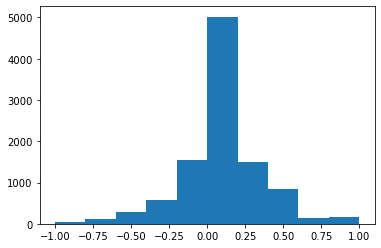

In [14]:
values, bins, _ = plt.hist(polarities)

In [16]:
bins

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [17]:
values

array([  40.,  116.,  281.,  584., 1538., 5017., 1506.,  834.,  149.,
        158.])

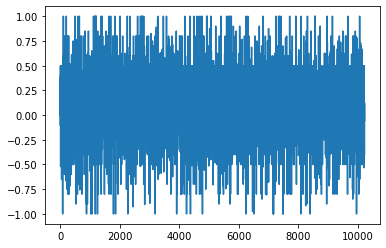

In [15]:
plt.plot(polarities)

### <a name="wordcloud"></a> 6. Wordcloud

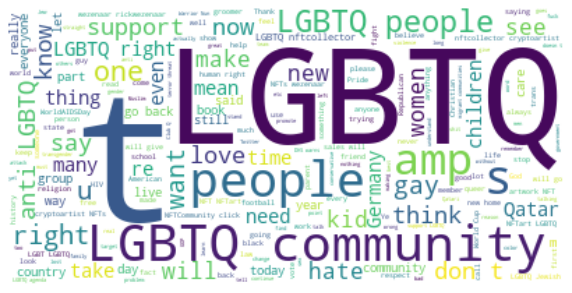

In [11]:
# Create a list of word
text= " ".join(tweet['text'] for index, tweet in df.iterrows())

# Create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(["http", "https", "co"])

# Create the wordcloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
 
# Display the generated image (matplotlib way):
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()